**Analysis owner**: Tamiris Crepalde <br>
**Date**: 09/01/2023 <br>

This analysis pretends to do an Exploratory Data Analysis of a dateset related to cancellations of travel packages.

Packages are a type of travel product that include flight tickets and hotel reservations.

### Setup

In [1]:
import os

import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

import src.utils as utils
from GoogleUtils import GoogleUtils

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
gutils = GoogleUtils()

### Load data

In [3]:
root = os.getcwd()

In [4]:
query = utils.read_file(f'{root}/src/queries/package_cancellation_data.sql')
df_cancel = gutils.read_from_bq(query)

/usr/local/lib/python3.7/dist-packages/google/cloud/bigquery/client.py:441: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [5]:
df_cancel.head()

,operation_order_id,operation_id,order_id,order_date,origin_city,order_origin_city,origin_state,origin_country,destination_type,destination_city,...,first_valid_date_brt,last_valid_date_brt,first_possible_wish_date_brt,first_wish_date_brt,second_wish_date_brt,third_wish_date_brt,operation_status_id,operation_status_name,last_update_status_date_brt,qty_status_changes
0,1104494281959795016,-4.989179e+17,-7201306185651796311,2019-10-15,Vitória,Vitória,Espírito Santo,Brasil,Nacional,Ipojuca,...,2020-03-01,2020-11-30,None,2020-07-31,2020-07-31,2020-07-31,11.0,Atribuído,2020-10-05,3
1,5934731260577427608,-8.826380e+18,-2980849355996525185,2020-04-15,Brasília,Brasília,Distrito Federal,Brasil,Internacional,Havana,...,2021-03-01,2023-11-30,None,2022-05-28,2022-11-05,2022-11-12,12.0,Contato sem sucesso,2022-09-28,3
2,4455764008553950886,-6.148565e+18,7194111542072774996,2020-04-22,São Paulo,São Paulo,São Paulo,Brasil,Internacional,Berlim,...,2021-03-01,2023-11-30,None,2022-09-11,2022-10-16,2022-10-23,14.0,Cancelada,2022-09-28,4
3,8337803680114393706,-6.240385e+18,-1414242056390973879,2021-07-11,São Paulo,São Paulo,São Paulo,Brasil,Nacional,Mata de São João,...,2022-08-01,2023-06-30,None,2022-09-26,2022-10-10,2022-11-07,14.0,Cancelada,2022-10-03,3
4,-2532933232498601062,NaN,-6272109269015092998,2021-08-11,São Paulo,São Paulo,São Paulo,Brasil,Internacional,Florença,...,2022-08-01,2023-06-30,None,2022-10-15,2023-04-14,2023-05-12,NaN,None,2021-09-30,2


Save locally:

In [6]:
df_cancel.to_csv(f'{root}/src/data/cancellation_data.csv')

### Data Cleaning

We have a lot of null values:

In [7]:
df_cancel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299963 entries, 0 to 299962
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   operation_order_id            299963 non-null  int64  
 1   operation_id                  154492 non-null  float64
 2   order_id                      299963 non-null  int64  
 3   order_date                    299963 non-null  object 
 4   origin_city                   299963 non-null  object 
 5   order_origin_city             299963 non-null  object 
 6   origin_state                  299963 non-null  object 
 7   origin_country                299963 non-null  object 
 8   destination_type              299963 non-null  object 
 9   destination_city              299963 non-null  object 
 10  destination_state             299963 non-null  object 
 11  destination_country           299963 non-null  object 
 12  qty_people                    299963 non-nul

- The feature `operation_id` indicates if the order started the process of being operated before the cancellation and the features `operation_status_id` and `operation_status_name` indicates the status of the operation process. The first feature we'll convert to boolean because we want to analyze if the client cancelled the order after the operation process started. 
- `origin_city` and `origin_state` miss more than half of the data, but `order_origin_city` has the same purpose of `origin_city`. So, we'll see if it's possible to consider the `order_origin_city` valid and if we can use it to try to fill up the missing data of `origin_state`. 
- We can drop the `origin_country` column because this product is offer only to Brazil.
- The feature `filled_form` is related to the client inform the desired dates to travel, so is enough if this information is boolean too. `first_form_fill_date_brt` and `last_form_fill_date_brt` are related to the first and last date in which the client filled up the form, we'll use these features only to verify if the process of filling up the form and the cancellation are close events.
- `first_possible_wish_date_brt` is completely empty, so we'll remove the column.
- The columns `first_wish_date_brt`, `second_wish_date_brt` and `third_wish_date_brt` are the wished dates to travel informed by half of the clients, at a first moment we'll not be concern about these information.
- The columns `operation_status_name` and `operation_status_id` are related to the status of the operation process, if a order was cancelled before the start of the operation, this information doesn't exists. So we'll use only the `operation_status_name` information, replacing the missing values with a non-started status name.
- The column `accommodation_type` has some missing data, we're going to look further on it before deciding if it will me removed or filled up.

Next we'll proceed to execute this modifications.

In [8]:
(df_cancel.isna().sum()/df_cancel.shape[0])*100

operation_order_id                0.000000
operation_id                     48.496315
order_id                          0.000000
order_date                        0.000000
origin_city                       0.000000
order_origin_city                 0.000000
origin_state                      0.000000
origin_country                    0.000000
destination_type                  0.000000
destination_city                  0.000000
destination_state                 0.000000
destination_country               0.000000
qty_people                        0.000000
qty_dailies                       0.000000
accommodation_type                7.566600
filled_form                       0.000000
first_form_fill_date_brt          0.000000
last_form_fill_date_brt           0.000000
first_valid_date_brt              0.001000
last_valid_date_brt               0.001000
first_possible_wish_date_brt    100.000000
first_wish_date_brt               0.001667
second_wish_date_brt              0.001667
third_wish_

Converting columns to boolean:

In [9]:
df = utils.convert_to_boolean(df_cancel, 'operation_id')
df = utils.convert_to_boolean(df, 'filled_form')

Looking at order_origin_city:

There's a lot of inconsistencies between the two cities columns, so we'll consider only the common information to fill up the state column.

In [10]:
df[['origin_city', 'order_origin_city']].loc[df[['origin_city', 'order_origin_city']].origin_city != df[['origin_city', 'order_origin_city']].order_origin_city].drop_duplicates()

,origin_city,order_origin_city
28642,Rio de Janeiro,São Paulo
117023,São Paulo,Cuiabá
218467,Rio de Janeiro,Su00e3o Paulo
237860,Porto Alegre,São Paulo
274338,Curitiba,Fortaleza
278701,São Paulo,Sao Paulo


In [11]:
city_state = df[['origin_city', 'order_origin_city', 'origin_state']].drop_duplicates().dropna(how='any')
city_state = city_state.loc[city_state.order_origin_city == city_state.origin_city]
city_state_dict = {city: city_state.loc[city_state.order_origin_city == city].origin_state.values[0] for city in city_state.order_origin_city.values}

In [12]:
city_state_dict

{'Vitória': 'Espírito Santo',
 'Brasília': 'Distrito Federal',
 'São Paulo': 'São Paulo',
 'Rio de Janeiro': 'Rio de Janeiro',
 'Recife': 'Pernambuco',
 'Curitiba': 'Paraná',
 'Salvador': 'Bahia',
 'Belo Horizonte': 'Minas Gerais',
 'Fortaleza': 'Ceará',
 'Porto Alegre': 'Rio Grande do Sul',
 'Belém': 'Pará',
 'Cuiabá': 'Mato Grosso',
 'Florianópolis': 'Santa Catarina',
 'Manaus': 'Amazonas',
 'Goiânia': 'Goiás',
 'Campo Grande': 'Mato Grosso do Sul',
 'Palmas': 'Tocantins',
 'Natal': 'Rio Grande do Norte',
 'Maceió': 'Alagoas',
 'João Pessoa': 'Paraíba',
 'Macapá': 'Amapá',
 'Campinas': 'São Paulo',
 'Aracaju': 'Sergipe',
 'Foz do Iguaçu': 'Paraná',
 'Boa Vista': 'Roraima',
 'Porto Velho': 'Rondônia',
 'Porto Seguro': 'Bahia',
 'Ribeirão Preto': 'São Paulo',
 'Vitoria da Conquista': 'Bahia',
 'Guarulhos': 'São Paulo',
 'Teresina': 'Piauí',
 'São Luís': 'Maranhão',
 'Rio Branco': 'Acre'}

In [13]:
df.loc[df.origin_state.isna(), 'origin_state'] = df['order_origin_city'].map(city_state_dict)

We were able to fill up all the missing state information:

In [14]:
(df.origin_state.isna().sum()/df.shape[0])*100

0.0

Drop some columns:

In [15]:
df = df.drop(['operation_order_id', 'operation_id', 'order_id', 'origin_country', 'first_possible_wish_date_brt', 'first_form_fill_date_brt', 'last_form_fill_date_brt', 'origin_city', 'first_wish_date_brt', 'second_wish_date_brt', 'third_wish_date_brt', 'operation_status_id'], axis=1)

Filling up the operation_status_name column:

In [16]:
df.loc[df.operation_status_name.isna(), 'operation_status_name'] = 'not started'

Looking at accommodation_type:

It's possible to notice that the column has the information of type varying even for the same room type. For instance, `Apartamento duplo` and `Apartamento duplo casal`. So we'll try to extract the main information of the column (individual, duplo, triplo, etc). In the cases where there's more than one option, we'll attribute a new type `multiple`. We'll attribute `not informed` for missing data.

In [17]:
df.loc[~df.accommodation_type.isna()].accommodation_type

0                                        Apartamento duplo.
1                                        Apartamento duplo.
2                                        Apartamento Duplo.
3         Quarto individual, duplo ou triplo, de acordo ...
4         Quarto individual, duplo ou triplo, de acordo ...
                                ...                        
299958    Quarto individual, duplo ou triplo, de acordo ...
299959                            Apartamento duplo casal. 
299960    Quarto duplo ou triplo, de acordo com a opção ...
299961                                   Apartamento Duplo.
299962                            Apartamento duplo casal. 
Name: accommodation_type, Length: 277266, dtype: object

In [18]:
df.loc[df.accommodation_type.isna(), 'accommodation_type'] = 'not informed'

In [19]:
df['accommodation_type'] = df.accommodation_type.str.lower()
df.loc[df.accommodation_type.str.contains(','), 'accommodation_type'] = 'multiple'
df.loc[df.accommodation_type.str.contains('individual'), 'accommodation_type'] = 'individual'
df.loc[df.accommodation_type.str.contains('dupl'), 'accommodation_type'] = 'duplo'
df.loc[df.accommodation_type.str.contains('tripl'), 'accommodation_type'] = 'triplo'

Now we can just drop the few rows with missing value:

In [20]:
df = df.dropna(how='any')

Now we're going to change the dtype of some columns:

In [21]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['first_valid_date_brt'] = pd.to_datetime(df['first_valid_date_brt'])
df['last_valid_date_brt'] = pd.to_datetime(df['last_valid_date_brt'])
df['last_update_status_date_brt'] = pd.to_datetime(df['last_update_status_date_brt'])

df['qty_people'] = df['qty_people'].astype(int)
df['qty_dailies'] = df['qty_dailies'].astype(int)

### Analysis

Let's start analyzing the data taking a look into the categorical data.

In [87]:
sns.set_style('darkgrid')
sns.set_palette(sns.color_palette())

In [23]:
categorical_features = df.select_dtypes(include=['object_']).columns

##### Origins

In [ ]:
origin_state = df.groupby('origin_state').count().order_date.reset_index()
origin_state = origin_state.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
origin_state['percent'] = origin_state.volume/origin_state.volume.sum()

Most of the cancelled orders are with origin in the states of São Paulo, Rio de Janeiro, Minas Gerais and Distrito Federal.

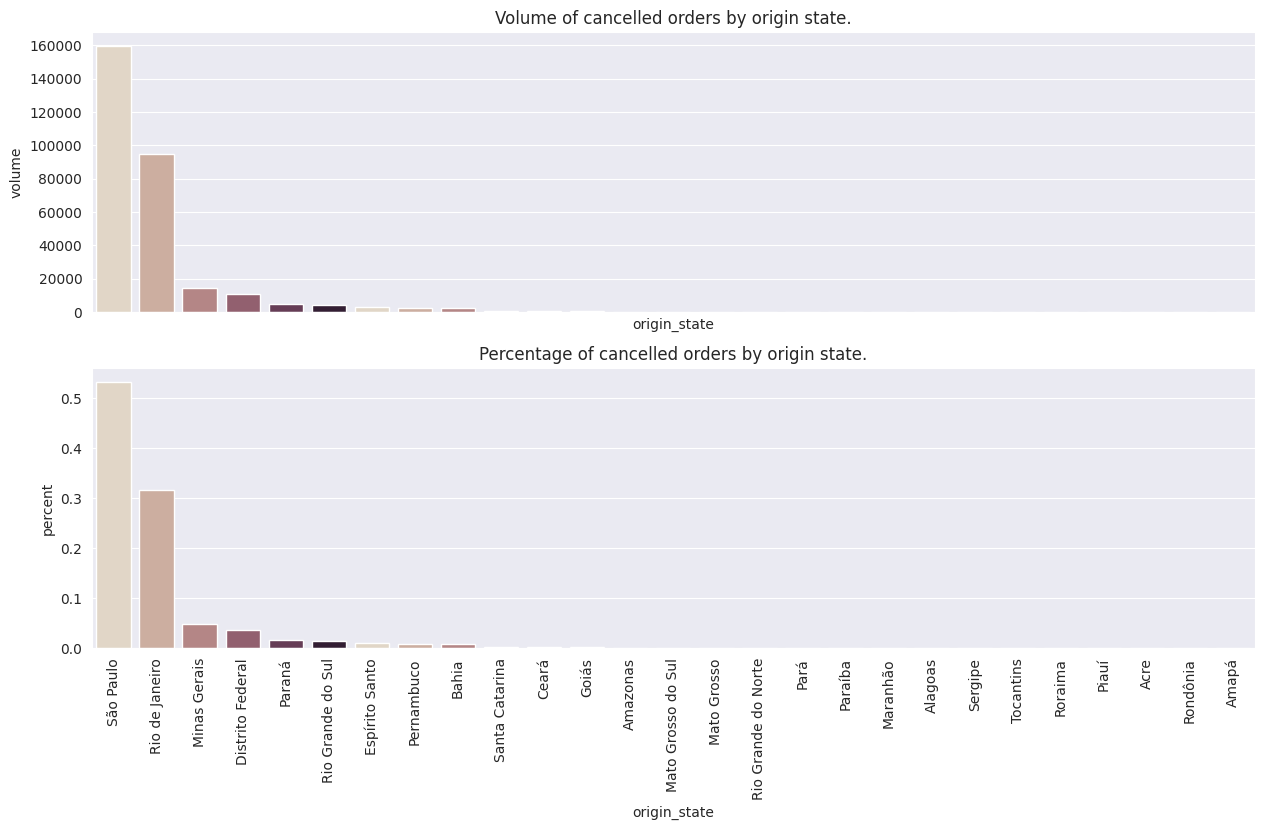

In [89]:
fig, ax = plt.subplots(2, sharex=True, figsize=(15,8))

sns.barplot(origin_state, x='origin_state', y='volume', ax=ax[0] , palette=sns.color_palette())
sns.barplot(origin_state, x='origin_state', y='percent', ax=ax[1], palette=sns.color_palette())

plt.xticks(rotation=90);
ax[0].set_title('Volume of cancelled orders by origin state.');
ax[1].set_title('Percentage of cancelled orders by origin state.');

In [24]:
origin_city = df.groupby('order_origin_city').count().order_date.reset_index()
origin_city = origin_city.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
origin_city['percent'] = origin_city.volume/origin_city.volume.sum()

We can verify that the 5 top origin cities are São Paulo, Rio de Janeiro, Belo Horizonte, Brasília and Curitiba. They represent almost 90% of the origins in this dataset.

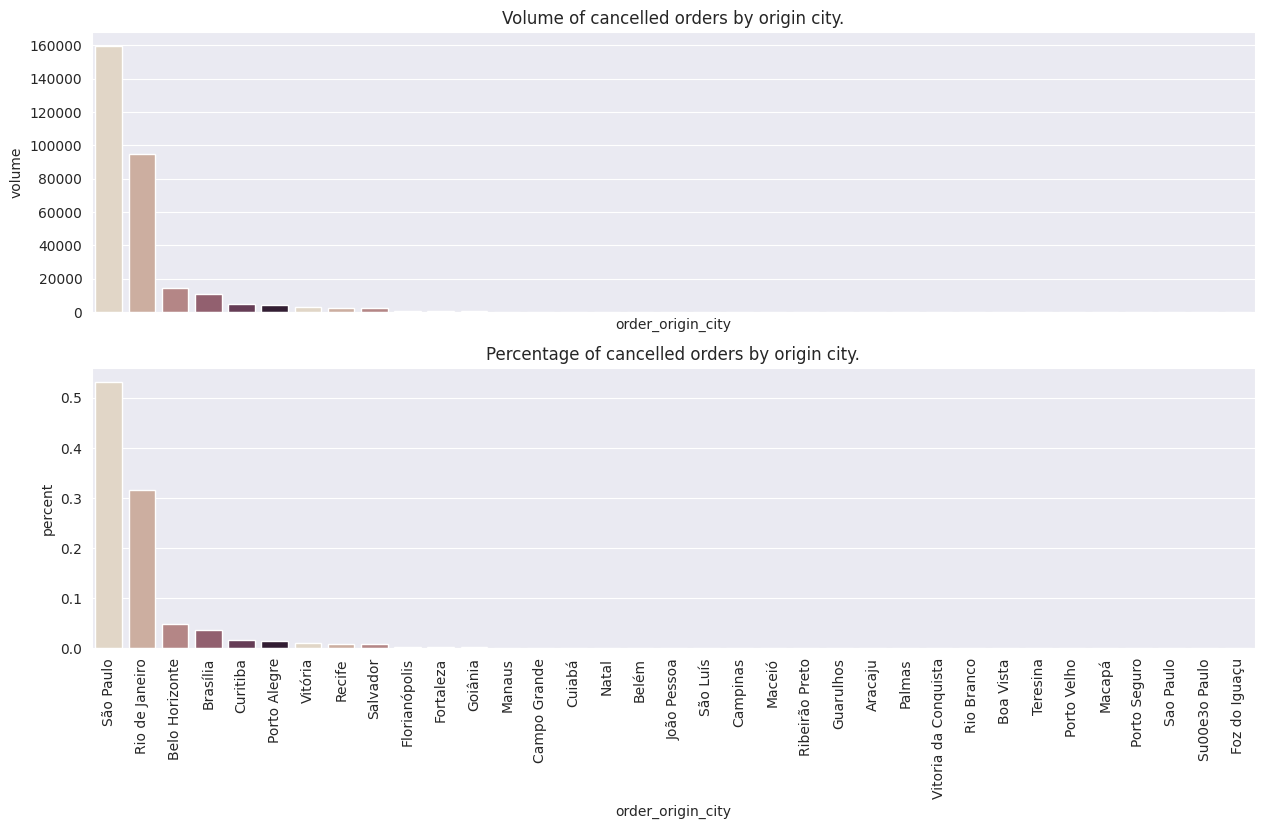

In [90]:
fig, ax = plt.subplots(2, sharex=True, figsize=(15,8))

sns.barplot(origin_city, x='order_origin_city', y='volume', ax=ax[0] , palette=sns.color_palette())
sns.barplot(origin_city, x='order_origin_city', y='percent', ax=ax[1], palette=sns.color_palette())

plt.xticks(rotation=90);
ax[0].set_title('Volume of cancelled orders by origin city.');
ax[1].set_title('Percentage of cancelled orders by origin city.');

##### Destinations

In [78]:
destination_type = df.groupby('destination_type').count().order_date.reset_index()
destination_type = destination_type.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
destination_type['percent'] = destination_type['volume']/df.shape[0]

More than 50% of the cancellations have national destination (Brazil).

<AxesSubplot:xlabel='destination_type', ylabel='percent'>

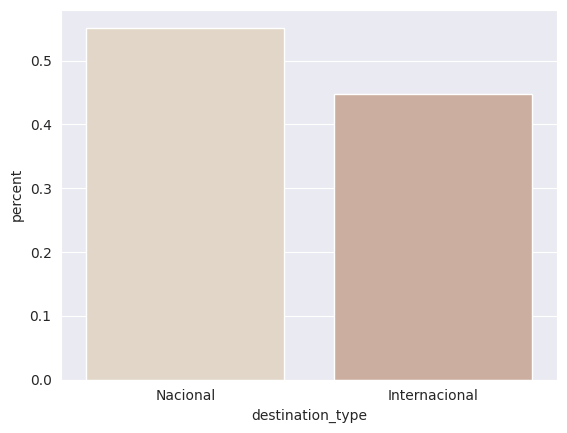

In [91]:
sns.barplot(destination_type, x='destination_type', y='percent')
plt.title('Percentage of cancellations by destinations type.')

In [92]:
destination_state = df.groupby('destination_state').count().order_date.reset_index()
destination_state = destination_state.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
destination_state['percent'] = destination_state.volume/destination_state.volume.sum()

We limited the plot to the top 35 destination states to keep the graph interpretable. It's possible to verify that in the top 10 destination state we have only two that are international: Flórida and Quintana Roo.

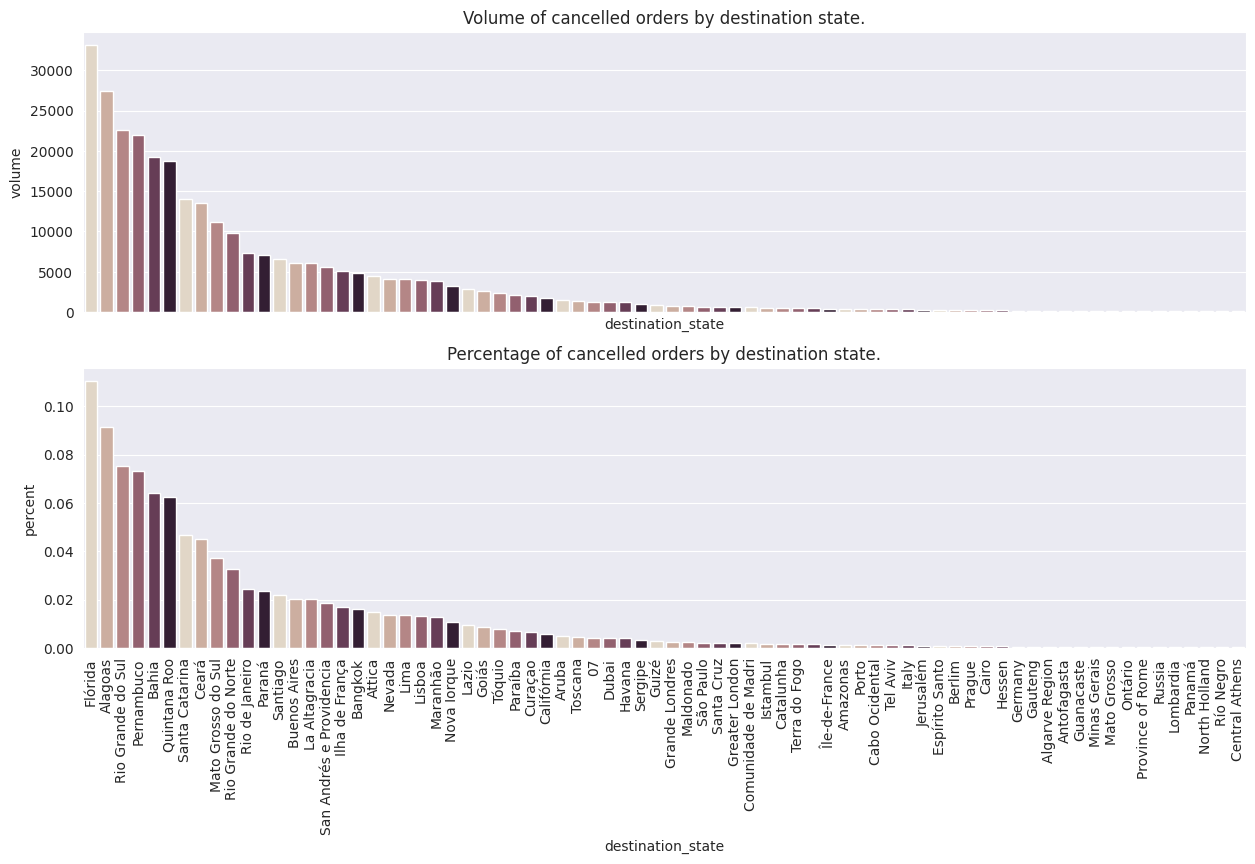

In [98]:
fig, ax = plt.subplots(2, sharex=True, figsize=(15,8))

sns.barplot(destination_state.loc[:35], x='destination_state', y='volume', ax=ax[0] , palette=sns.color_palette());
sns.barplot(destination_state.loc[:35], x='destination_state', y='percent', ax=ax[1], palette=sns.color_palette());

plt.xticks(rotation=90);
ax[0].set_title('Volume of cancelled orders by destination state.');
ax[1].set_title('Percentage of cancelled orders by destination state.');

In [99]:
destination_city = df.groupby('destination_city').count().order_date.reset_index()
destination_city = destination_city.rename(columns={'order_date': 'volume'}).sort_values('volume', ascending=False)
destination_city['percent'] = destination_city.volume/destination_city.volume.sum()

Among the top cities within cancellations, we have the to related to the international states mentioned before: Orlando (Florida) and Cancún (Quintana Roo).And a lot of Brazilian cities.

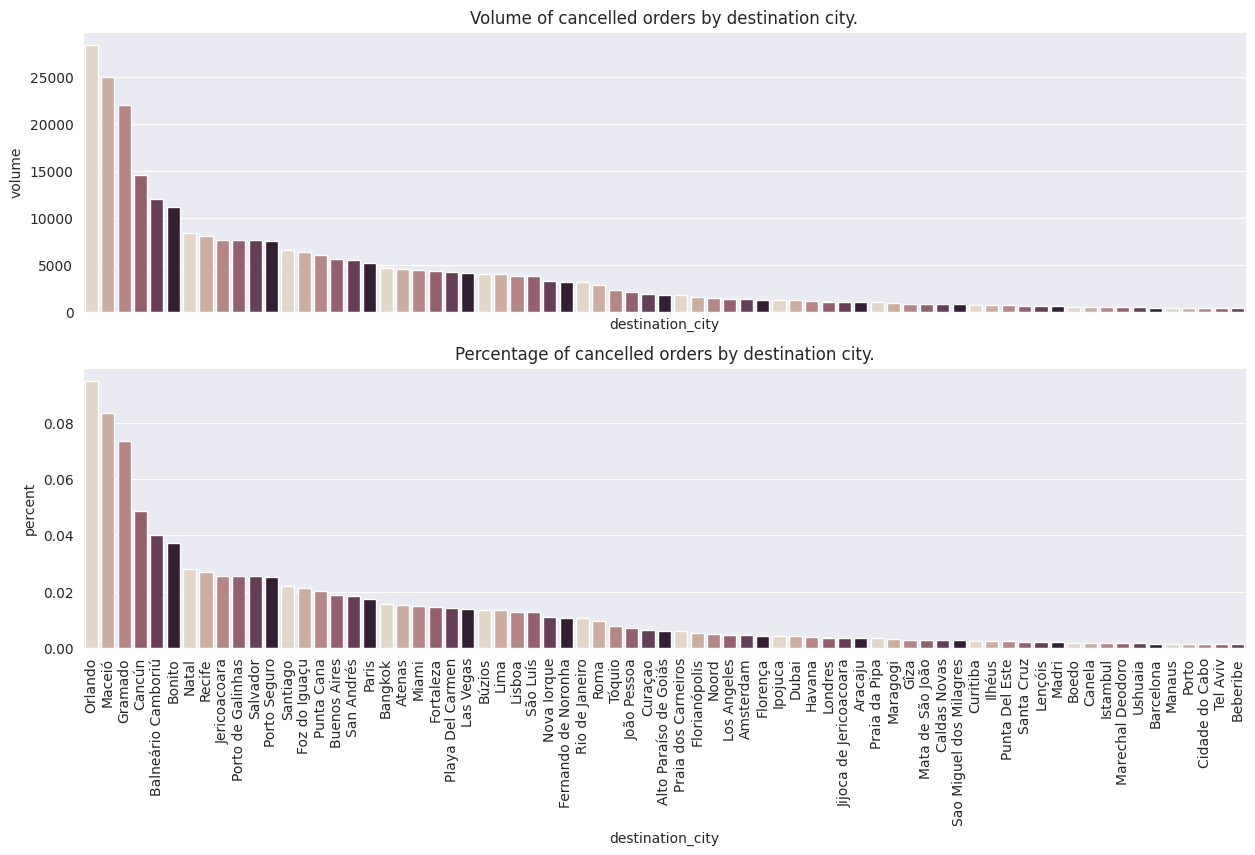

In [103]:
fig, ax = plt.subplots(2, sharex=True, figsize=(15,8))

sns.barplot(destination_city.loc[:30], x='destination_city', y='volume', ax=ax[0] , palette=sns.color_palette())
sns.barplot(destination_city.loc[:30], x='destination_city', y='percent', ax=ax[1], palette=sns.color_palette())

plt.xticks(rotation=90);
ax[0].set_title('Volume of cancelled orders by destination city.');
ax[1].set_title('Percentage of cancelled orders by destination city.');

TO DO **maybe try to plot a Sankey graph**